## Setup

In [ ]:
! brew install git python3 cmake sdl2 sdl2_image sdl2_ttf sdl2_gfx boost boost-python3
! python3 -m pip install --upgrade pip setuptools psutil wheel

In [ ]:
! pip install gfootball 

In [ ]:
! pip install setuptools==65.5.0
! git clone https://github.com/google-research/football.git
! cd football && pip install . 

### Test game play

In [127]:
! python -m gfootball.play_game --action_set=full

objc[81026]: Class SDLApplication is implemented in both /opt/homebrew/Cellar/sdl2/2.26.3/lib/libSDL2-2.0.0.dylib (0x106368800) and /Users/georgipachov/opt/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x1321287e8). One of the two will be used. Which one is undefined.
objc[81026]: Class SDLAppDelegate is implemented in both /opt/homebrew/Cellar/sdl2/2.26.3/lib/libSDL2-2.0.0.dylib (0x106368850) and /Users/georgipachov/opt/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x132128838). One of the two will be used. Which one is undefined.
objc[81026]: Class SDLTranslatorResponder is implemented in both /opt/homebrew/Cellar/sdl2/2.26.3/lib/libSDL2-2.0.0.dylib (0x1063688c8) and /Users/georgipachov/opt/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x1321288b0). One of the two will be used. Which one is undefined.
objc[81026]: Class SDLMessageBoxPresenter is implemented in both /opt/h

### Learning environment 

In [208]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gym
import numpy as np
import os
from collections import namedtuple
import gfootball
import gfootball.env as football_env
from gfootball.env.wrappers import Simple115StateWrapper
import collections

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

class ShapingRewardWrapper(gym.Wrapper):
        def __init__(self, env):
            super().__init__(env)
            self.observation_space = collections.namedtuple('ObservationSpace', 'shape')
            self.observation_space.shape=(115,)
            self._env = env

            self._bo = 0.02
            
            # attack vs defense coefficients
            self._dist_mg = 0.01
            self._dist_og = 0.01
            
            self._opdist = 0.1
            self._goal_bonus = 100

        
        def step(self, action):
            obs, reward, done, info = self._env.step(action)
            reward *= self._goal_bonus
            obs = obs[0]

            if obs['ball_owned_team'] == 0:
                reward += self._bo
            elif obs['ball_owned_team'] == 1:
                reward -= self._bo

            bx, by, bz = obs['ball']
            mgx, mgy = -1, 0
            ogx, ogy = 1, 0
            
            dist_from_my_goal = (np.sqrt((bx-mgx)**2 + (by-mgy)**2))
            dist_from_opponent_goal = (np.sqrt((bx-ogx)**2 + (by-ogy)**2))
            
            reward += self._dist_mg * dist_from_my_goal
            reward += self._dist_og * dist_from_opponent_goal

            # distance of controlling player from ball 
            mx, my = obs['left_team'][obs['active']]
            if obs['ball_owned_team'] != 0:
                reward -= self._opdist * (np.sqrt((bx-mx)**2 + (by-my)**2))
                
            return obs, reward, done, info

        
def obs_transform(obs):
    return Simple115StateWrapper.convert_observation(obs, True)


def create_env(render=False, 
               env_name='academy_empty_goal', 
               wrapper_init=None,
               record=True,
               **params):
    if env_name == 'cart_pole':
        env = gym.make('CartPole-v0')
    else:
        env_names = ['1_vs_1_easy', '5_vs_5', 'academy_run_to_score', 'academy_empty_goal_close', 'academy_empty_goal']
        os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.3'
        env = football_env.create_environment(env_name=env_name, 
                                              stacked=False, 
                                              representation='raw',
                                              rewards='scoring,checkpoints',
                                              logdir='replays', 
                                              write_goal_dumps=record, 
                                              write_full_episode_dumps=record, 
                                              write_video=record,
                                              render=render)
        if wrapper_init is not None:
            return wrapper_init.__call__(env)
        else:
            return env


class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(115, 128)

        # actor's layer
        self.action_head = nn.Linear(128, 19)

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))

        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values


def select_action(model, state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    return action.item()


def finish_episode(model, optimizer, gamma, eps=1e-8):
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]


### Learning objective: Empty Goal

In [48]:
class DistanceFromOpponentGoalReward(gym.Wrapper):
        def __init__(self, env):
            super().__init__(env)
            self._env = env
        
        def step(self, action):
            obs, reward, done, info = self._env.step(action)
            reward = 0
            
            obs = obs[0]

            bx, by, bz = obs['ball']
            ogx, ogy = -1, 0
            
            dist_from_opponent_goal = (np.sqrt((bx-ogx)**2 + (by-ogy)**2))
            reward -= dist_from_opponent_goal
            
            return obs, reward, done, info
        
class DistanceFromOpponentGoalRewardFixed(gym.Wrapper):
        def __init__(self, env):
            super().__init__(env)
            self._env = env
        
        def step(self, action):
            obs, reward, done, info = self._env.step(action)
            reward = 0
            
            obs = obs[0]

            bx, by, bz = obs['ball']
            ogx, ogy = 1, 0
            
            dist_from_opponent_goal = (np.sqrt((bx-ogx)**2 + (by-ogy)**2))
            reward -= dist_from_opponent_goal
            
            return obs, reward, done, info

In [188]:
def run_agent(exp_name='exp1',
              model=None,
              train=True,
              render=False,
              record=False, 
              num_episodes=2000,
              num_steps=500,
              task='academy_empty_goal_close',
              wrapper_init=DistanceFromOpponentGoalReward,
              policy_fn=Policy,
              solved_threshold=-25,
              log_every=50,
              learning_rate=1e-2,
              gamma=0.99,
              last_n=5,
              seed=0,
              checkpoint=True,
              checkpoint_dir='checkpoints'
             ):
    # set seed first
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    
    try: 
        max_reward = -1_000_000
        running_reward = 0
        episode_rewards = []
        env = create_env(render=render, 
                         env_name=task,
                         record=record,
                         wrapper_init=wrapper_init)
        if model is None:
            model = policy_fn()
            
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        # eps = np.finfo(np.float32).eps.item()
        eps = 1e-8

        # run inifinitely many episodes
        for i_episode in range(num_episodes):
            # reset environment and episode reward
            state = env.reset()
            state = obs_transform(state)
            ep_reward = 0

            # for each episode, only run 9999 steps so that we don't 
            # infinite loop while learning
            for t in range(1, num_steps):

                # select action from policy
                action = select_action(model, state)

                # take the action
                state, reward, done, _ = env.step(action)
                state = obs_transform([state])

                model.rewards.append(reward)
                ep_reward += reward
                if done:
                    break

                    
            # log results
            episode_rewards.append(ep_reward)
            
            # update cumulative reward
            running_reward = np.mean(episode_rewards[-last_n:])
            
            if i_episode % log_every == 0:
                print(f'Episode: {i_episode}\tLast reward: {ep_reward:.2f} \t Last {last_n} episodes average reward: {running_reward}')

            if train:
                # save checkpoint
                if checkpoint:
                    if running_reward > max_reward:
                        torch.save(model, f'{checkpoint_dir}/{running_reward}_{task}_{exp_name}_checkpoint_{i_episode}.h5')
                        max_reward = running_reward

                if i_episode > last_n and running_reward > solved_threshold:
                    torch.save(model, f'{task}_{exp_name}.h5')
                    print('Solved!')
                    return model, episode_rewards
                
                else:
                    # perform backprop
                    finish_episode(model, optimizer, gamma)
                
        return model, episode_rewards
    finally: 
        env.close()
        
def load_best_agent(checkpoints_dir='checkpoints'):
    # Load best agent
    checkpoints = os.listdir(checkpoints_dir)
    all_checkpoints = {int(x[:x.index('.')]):x for x in checkpoints}
    max_reward = max(all_checkpoints.keys())
    best = all_checkpoints[max_reward]
    print('Loading checkpoint: ', best)
    model_loaded = torch.load(os.path.join(checkpoints_dir, best))
    return model_loaded

def load_agent(name, checkpoints_dir='checkpoints'):
    # Load manually
    print('Loading checkpoint: ', name)
    model_loaded = torch.load(os.path.join(checkpoints_dir, best))
    return model_loaded

### Walk towards goal

In [64]:
model, episode_rewards = run_agent(train=True, 
                                   render=False, 
                                   record=False, 
                                   log_every=50, 
                                   seed=42, 
                                   last_n=20, 
                                   solved_threshold=-56, 
                                   task='academy_empty_goal', 
                                   wrapper_init=DistanceFromOpponentGoalRewardFixed)

Episode: 0	Last reward: -58.61 	 Last 20 episodes average reward: nan


/var/folders/4x/vb5tl80s45v2f_k7_zb004bc0000gn/T/ipykernel_55135/2604414573.py:171: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))


Episode: 50	Last reward: -59.12 	 Last 20 episodes average reward: -61.18119228855572
Episode: 100	Last reward: -61.10 	 Last 20 episodes average reward: -57.828025449467816
Episode: 150	Last reward: -55.73 	 Last 20 episodes average reward: -63.64272469552509
Solved!


<AxesSubplot: title={'center': 'Mean reward for last 20 episodes'}, xlabel='Еpisode', ylabel='Reward'>

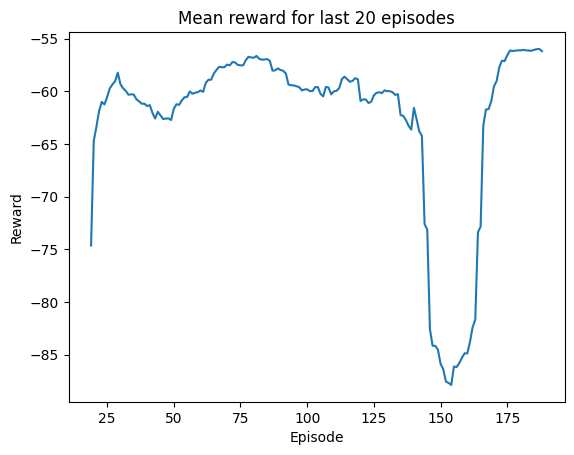

In [73]:
pd.Series(episode_rewards[10:]).rolling(20).mean().plot(xlabel='Еpisode', ylabel='Reward', title='Mean reward for last 20 episodes')

In [74]:
run_agent(model=model, train=False, render=True, record=True, num_episodes=1, task='academy_empty_goal', wrapper_init=DistanceFromOpponentGoalRewardFixed)

Episode: 0	Last reward: -56.39 	 Last 5 episodes average reward: nan


(Policy(
   (affine1): Linear(in_features=115, out_features=128, bias=True)
   (action_head): Linear(in_features=128, out_features=19, bias=True)
   (value_head): Linear(in_features=128, out_features=1, bias=True)
 ),
 [-56.39224261976783])

### Shoot-walk-shoot

In [ ]:
model, episode_rewards = run_agent(train=True, 
                                   render=False, 
                                   record=False, 
                                   log_every=50, 
                                   seed=42, 
                                   last_n=1, 
                                   solved_threshold=-10, 
                                   task='academy_empty_goal', 
                                   learning_rate=5e-3,
                                   wrapper_init=DistanceFromOpponentGoalRewardFixed)

<AxesSubplot: title={'center': 'Mean reward for last 20 episodes'}, xlabel='Еpisode', ylabel='Reward'>

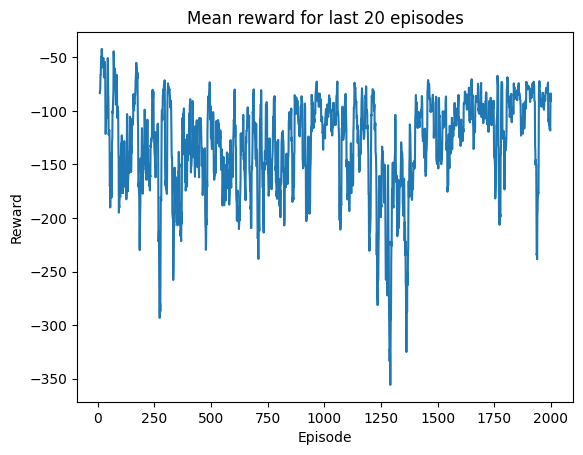

In [172]:
pd.Series(episode_rewards).rolling(10).mean().plot(xlabel='Еpisode', ylabel='Reward', title='Mean reward for last 20 episodes')

In [190]:
model_loaded = load_best_agent()

Loading checkpoint:  -17.757373457463476_academy_empty_goal_exp1_checkpoint_37.h5


In [189]:
# Load manually(
model_loaded = load_agent('-17.757373457463476_academy_empty_goal_exp1_checkpoint_37.h5')

Loading checkpoint:  -17.757373457463476_academy_empty_goal_exp1_checkpoint_37.h5


In [178]:
run_agent(model=model_loaded, 
          train=False, 
          render=True, 
          record=True,
          seed=42, 
          num_episodes=13,
          task='academy_empty_goal', 
          wrapper_init=DistanceFromOpponentGoalRewardFixed)

Episode: 0	Last reward: -137.44 	 Last 5 episodes average reward: -137.43623803869036


(Policy(
   (affine1): Linear(in_features=115, out_features=128, bias=True)
   (action_head): Linear(in_features=128, out_features=19, bias=True)
   (value_head): Linear(in_features=128, out_features=1, bias=True)
 ),
 [-137.43623803869036,
  -39.967329048777124,
  -98.43204530529466,
  -131.97627949764987,
  -41.84674341396882,
  -136.371822608663,
  -31.591023862909807,
  -30.12944717478888,
  -29.065771891304784,
  -17.31319572070514,
  -30.569423063414266,
  -224.14599243525038,
  -44.47570875120216])

### Shorter episodes

In [185]:
model, episode_rewards = run_agent(train=True, 
                                   render=False, 
                                   record=False, 
                                   num_steps=100,
                                   log_every=50, 
                                   seed=42, 
                                   last_n=10, 
                                   solved_threshold=-10, 
                                   task='academy_empty_goal', 
                                   learning_rate=5e-1,
                                   wrapper_init=DistanceFromOpponentGoalRewardFixed)

Episode: 0	Last reward: -58.61 	 Last 10 episodes average reward: -58.61228778966569


/var/folders/4x/vb5tl80s45v2f_k7_zb004bc0000gn/T/ipykernel_55135/2604414573.py:171: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))


Episode: 50	Last reward: -23.40 	 Last 10 episodes average reward: -49.69676967583298
Episode: 100	Last reward: -32.08 	 Last 10 episodes average reward: -34.91516216443094
Episode: 150	Last reward: -22.25 	 Last 10 episodes average reward: -24.21435086285247
Episode: 200	Last reward: -29.51 	 Last 10 episodes average reward: -25.029860890926926
Episode: 250	Last reward: -22.86 	 Last 10 episodes average reward: -26.931162259906774
Episode: 300	Last reward: -23.67 	 Last 10 episodes average reward: -23.13044461013999
Episode: 350	Last reward: -27.39 	 Last 10 episodes average reward: -26.94248860501773
Episode: 400	Last reward: -25.97 	 Last 10 episodes average reward: -23.473926951790066
Episode: 450	Last reward: -29.03 	 Last 10 episodes average reward: -25.444612796430057
Episode: 500	Last reward: -26.77 	 Last 10 episodes average reward: -25.48951564830205
Episode: 550	Last reward: -28.56 	 Last 10 episodes average reward: -25.692326489085353
Episode: 600	Last reward: -26.70 	 Last

<AxesSubplot: title={'center': 'Mean reward for last 20 episodes'}, xlabel='Еpisode', ylabel='Reward'>

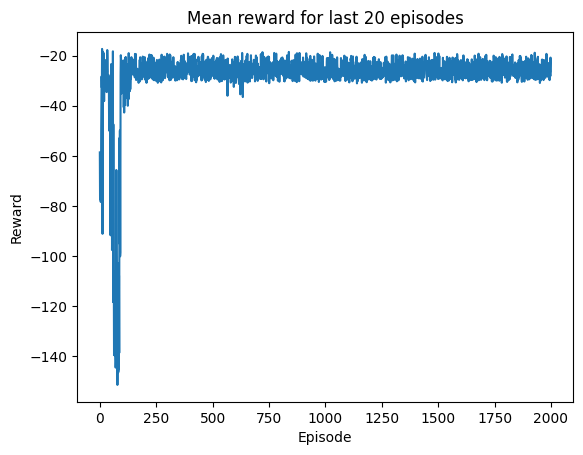

In [197]:
pd.Series(episode_rewards).plot(xlabel='Еpisode', ylabel='Reward', title='Mean reward for last 20 episodes')

In [216]:
model_loaded = load_agent('-24.49205928256362_academy_empty_goal_exp1_checkpoint_147.h5')

Loading checkpoint:  -24.49205928256362_academy_empty_goal_exp1_checkpoint_147.h5


In [210]:
model_loaded = torch.load('run_and_shoot_academy_empty_goal_exp1.h5')

In [219]:
run_agent(model=model, 
          train=False, 
          render=True, 
          record=True,
          seed=42, 
          num_episodes=10,
          task='academy_empty_goal', 
          wrapper_init=DistanceFromOpponentGoalRewardFixed)

Episode: 0	Last reward: -23.17 	 Last 5 episodes average reward: -23.16650668305341


(Policy(
   (affine1): Linear(in_features=115, out_features=128, bias=True)
   (action_head): Linear(in_features=128, out_features=19, bias=True)
   (value_head): Linear(in_features=128, out_features=1, bias=True)
 ),
 [-23.16650668305341,
  -30.838303625372866,
  -27.42340785837877,
  -25.452735285422282,
  -28.85583940061469,
  -21.87234821909026,
  -25.44439838383388,
  -28.57704374489157,
  -25.927394332235238,
  -25.600225606928948])

In [148]:
# https://github.com/google-research/football/blob/master/gfootball/doc/observation.md#raw-observations

In [ ]:
# academy_empty_goal_close
# academy_empty_goal
# academy_run_to_score
# academy_run_to_score_with_keeper
